---
format: 
  html: default
  typst: default
jupyter: python3
---

# Inversión de sondeo eléctrico vertical (VES)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import chi2
import pygimli as pg
from pygimli.physics.ves import VESManager, VESModelling, VESRhoModelling
from pygimli.frameworks.lsqrinversion import LSQRInversion
from pygimli.frameworks.resolution import modelCovariance
from pygimli.frameworks import MarquardtInversion
from pygimli.viewer.mpl import drawModel1D

## Cargar datos

Cargamos los datos del sondeo eléctrico vertical (VES) desde un archivo de texto, usando la librería `pandas`. El archivo contiene columnas para la separación AB/2, MN y la resistividad aparente. Ajustamos los nombres de las columnas para facilitar su uso posterior. Los datos se pueden cargar también con `numpy` y luego convertirlos a un DataFrame de `pandas`.

In [3]:
data = pd.read_table("datos/curso_geofisica/datos/SEV1.TXT")
print(data.head())
vescode = "SEV-1" # Código del sondeo, nombre a usar en archivos de salida

# ab2, mn, roa = np.genfromtxt("curso_geofisica/datos/SEV1.TXT", 
#                              skip_header=1,
#                              unpack=True)

# data = pd.DataFrame(data={'ab2':ab2,'mn':mn,'roa':rhoa})

   AB/2   MN  Ro_a
0   1.0  0.5  6.85
1   2.0  0.5  8.35
2   2.5  0.5  8.33
3   3.0  0.5  8.95
4   4.0  0.5  9.99


In [4]:
data.columns = ["ab2", "mn", "roa"]
print(data.head())

   ab2   mn   roa
0  1.0  0.5  6.85
1  2.0  0.5  8.35
2  2.5  0.5  8.33
3  3.0  0.5  8.95
4  4.0  0.5  9.99


## Empate de datos (varios MN) y limpieza

En caso de que existan valores repetidos en AB/2 (como es el caso del arreglo Schlumberger por tener diferentes valores de MN), ajustamos (empatamos) los valores de resistividad aparente para evitar problemas en la inversión, y que la curva de datos sea monótona. Además, eliminamos los valores duplicados y reiniciamos los índices del DataFrame.

In [5]:
for w in range(data.shape[0]-1):
    if data["ab2"].values[w+1] == data["ab2"].values[w]:
        diff = data["roa"].values[w] - data["roa"].values[w+1]
        data["roa"].values[w+1:] = data["roa"].values[w+1:] + diff
        continue

data.drop_duplicates(subset=["ab2","roa"], inplace=True)
data.reset_index(drop=True, inplace=True)

Si existen valores atípicos en los datos, se pueden eliminar. En este caso, el valor con índice 19 es un valor atípico evidente, ver gráfico de datos más abajo. Además, reiniciamos los índices del DataFrame.

In [6]:
data.drop(19, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

## Crear variables de datos

Guardamos los datos en variables para su posterior uso. Como MN en el archivo es el doble de MN/2, lo dividimos entre 2, ya que es el valor requerido por PyGIMLi. En caso de tener otros archivos de datos, se deben ajustar los nombres de las columnas según corresponda, o se cambian los nombres de las columnas del DataFrame (como se muestra arriba) por estos genéricos.

In [7]:
ab2 = data["ab2"].values 
mn2 = data["mn"].values / 2 # Ajuste para MN/2 en caso de requerirlo
rhoa = data["roa"].values 
err = np.ones_like(rhoa) * 0.05 # Error relativo en los datos (5%)

## Grafica de datos

Primero visualizamos los datos de resistividad aparente en función de la separación AB/2 en una escala log-log. Esto nos permite observar la variación de la resistividad aparente con la profundidad efectiva del sondeo, ver si hay valores atípicos, y tener una idea inicial del modelo subsuperficial.

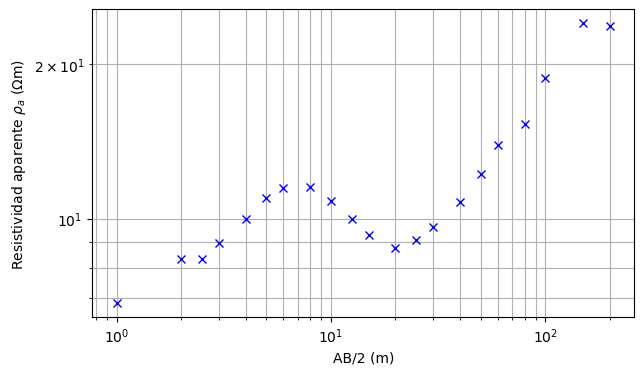

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
ax.loglog(ab2, rhoa, "x", color='blue', label="data")
ax.set_ylabel(r"Resistividad aparente $\rho_a$ ($\Omega$m)")
ax.set_xlabel("AB/2 (m)")
ax.grid(True, which='both')

# plt.savefig("figs/" + vescode + ".png", dpi=300, bbox_inches='tight')

## Ajuste manual

Definimos un modelo inicial de capas con espesores y resistividades. Este modelo se utiliza como punto de partida para la inversión. Luego, usamos `VESManager` para realizar una inversión sin iteraciones (maxIter=0) y observar cómo se ajusta el modelo inicial a los datos.

In [9]:
espesores = [1, 5, 13] # Espesores de las capas (m)
resistividades = [6, 15, 5, 32] # Resistividades de las capas (Ohm.m)
modelM = espesores + resistividades

In [10]:
vesM = VESManager(ab2=ab2, 
                  mn2=mn2
                  )

In [11]:
ncapasm = len(resistividades) # Número de capas en el modelo
Lam = 20 # Parámetro de suavizado

In [12]:
vesM.invert(rhoa, err, 
            nLayers=ncapasm, 
            lam=Lam, lambdaFactor=0.8,
            startModel=modelM,
            maxIter=0, # para que no haga iteraciones/inversión
            )

07/11/25 - 08:49:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


7 [1.0, 5.0, 13.0, 6.0, 15.0, 5.0, 32.0]

In [13]:
print(f"\u03C7^2: {vesM.inv.chi2():.2f}")
print(f"Rel RMS: {vesM.inv.relrms():.2f} %")

χ^2: 1.03
Rel RMS: 4.96 %


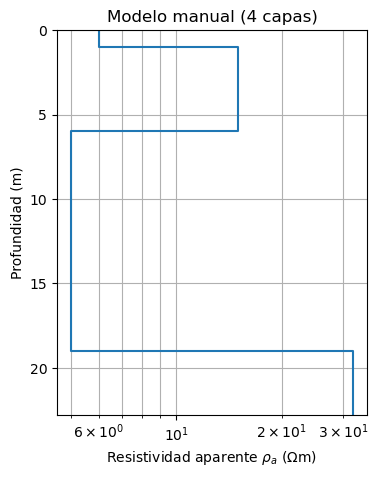

In [ ]:
fig, ax = plt.subplots(figsize=(4,5))
vesM.showModel(model=modelM, ax=ax, plot='semilogx')
ax.set_xlabel(r"Resistividad aparente $\rho_a$ ($\Omega$m)")
ax.set_ylabel("Profundidad (m)")
ax.set_title("Modelo manual" + f" ({ncapasm} capas)")
ax.grid(True, which='both')

# plt.savefig("figs/" + vescode + "-manual-" + str(ncapasm) + "capas.png", dpi=300, bbox_inches='tight')

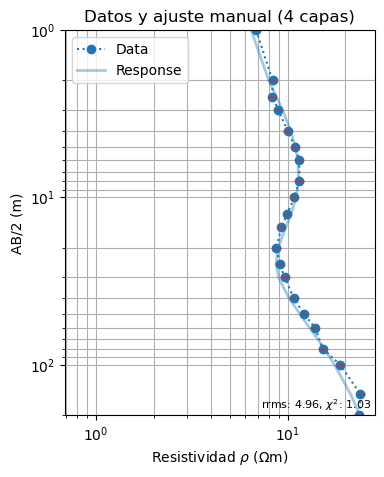

In [ ]:
fig, ax = plt.subplots(figsize=(4,5))
vesM.showFit(ax=ax)
# drawModel1D(model=modelM, ax=ax, label="Modelo", plot='loglog'); ax.set_ylim(max(ab2)*1.1, min(ab2)*0.9)
ax.set_xlabel(r"Resistividad $\rho$ ($\Omega$m)")
ax.set_ylabel("AB/2 (m)")
ax.set_title("Datos y ajuste manual" + f" ({ncapasm} capas)")
ax.grid(True, which='both')
ax.legend(loc='best')

# plt.savefig("figs/" + vescode + "-manual-ajuste-" + str(ncapasm) + "capas.png", dpi=300, bbox_inches='tight')

## Inversión con espesores fijos

Si se tiene conocimiento previo de los espesores de las capas (pozo, estudios previos, etc.), se puede realizar una inversión con estos espesores fijos, ajustando solo las resistividades. Aquí vamos a usar los espesores definidos en el modelo manual.

In [19]:
f_r = VESRhoModelling(thk=espesores, ab2=ab2, mn2=mn2, nLayers=ncapasm)

inv_r = pg.Inversion(fop=f_r, verbose=False)
inv_r.dataTrans = 'log'
inv_r.modelTrans = 'log'
res_r = inv_r.run(rhoa, err)

07/11/25 - 08:55:33 - pyGIMLi - INFO - Found 1 regions.


In [ ]:
print(f"\u03C7^2: {inv_r.chi2():.2f}")
print(f"Rel RMS: {inv_r.relrms():.2f} %")

Vemos el modelo y su ajuste con los datos. La línea de código comentada permite comparar con el modelo manual definido anteriormente, así como mostrar la leyenda.

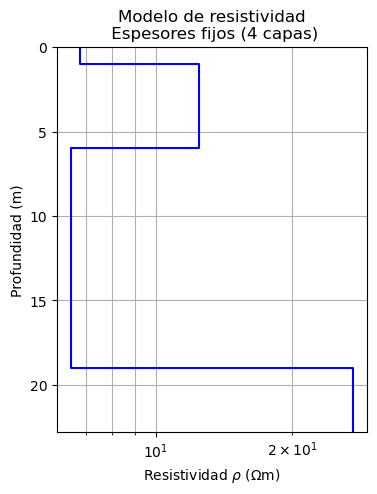

In [20]:
fig, ax = plt.subplots(figsize=(4,5))
drawModel1D(ax, espesores, res_r, color='blue', label="Espesores fijos", plot='semilogx')
# drawModel1D(model=modelM, ax=ax, color='orange', label="Manual", plot='semilogx'); ax.legend(loc='best')
ax.set_xlabel(r"Resistividad $\rho$ ($\Omega$m)")
ax.set_ylabel("Profundidad (m)")
ax.set_title("Modelo de resistividad\n Espesores fijos (" + str(ncapasm) + " capas)")
ax.grid(True, which='both')

# plt.savefig("figs/" + vescode + "-espesores-fijos-" + str(ncapasm) + "capas.png", dpi=300, bbox_inches='tight')

<positron-console-cell-21>:6: SyntaxWarning: invalid escape sequence '\c'


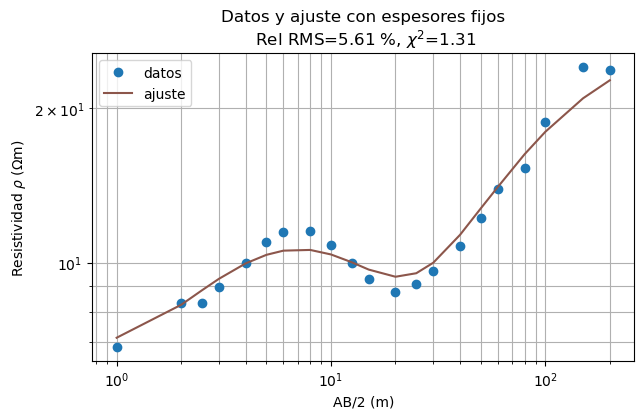

In [21]:
fig, ax = plt.subplots(figsize=(7,4))
ax.loglog(ab2, rhoa, 'o', color="C0", label='datos')
ax.loglog(ab2, inv_r.response, '-', color="C5", label='ajuste')
ax.set_xlabel("AB/2 (m)")
ax.set_ylabel(r"Resistividad $\rho$ ($\Omega$m)")
ax.set_title("Datos y ajuste con espesores fijos\n Rel RMS={:.2f} %, $\chi^2$={:.2f}".format(inv_r.relrms(), inv_r.chi2()))
ax.grid(True, which='both')
ax.legend(loc='best')

# plt.savefig("figs/" + vescode + "-espesores-fijos-ajuste-" + str(ncapasm) + "capas.png", dpi=300, bbox_inches='tight')

## Inversión fijando espesor(es) y/o resistividad(es)

Si se tiene conocimiento previo de algún espesor o resistividad en particular, se puede fijar ese parámetro durante la inversión. Aquí se muestra un ejemplo fijando el espesor de la segunda capa a 5 m.

In [22]:
f_f = VESModelling(ab2=ab2, mn2=mn2, nLayers=ncapasm)

inv_f = LSQRInversion(fop=f_f, verbose=True)
inv_f.dataTrans = 'log'
inv_f.modelTrans = 'log'
inv_f.inv.setMarquardtScheme()

Para fijar un parámetro, se crea una matriz `G` que indica qué parámetro del modelo se va a fijar (1 en la posición correspondiente al parámetro, 0 en las demás), y un vector `c` con el valor fijo deseado. Recordar que el modelo está organizado primero con los espesores (número de capas - 1) y luego con las resistividades (número de capas). Si se desea fijar más de un parámetro a la vez, se agregan más filas a la matriz `G` y más valores al vector `c`.

In [23]:
param_f = 1 # Cantidad de parámetros a fijar

G = pg.Matrix(rows=param_f, cols=len(modelM))
G.setVal(0, 1, 1) # Fijar el espesor de la segunda capa (índice 1)

c = pg.Vector(param_f) 
c[0] = 5.0 # Valor fijo del espesor de la segunda capa

Se usa el método `setParameterConstraints` para aplicar esta restricción en la inversión. Es necesario definir un modelo inicial, por lo que se usa el modelo manual definido anteriormente.

In [24]:
inv_f.setParameterConstraints(G, c, 100)
model_f = inv_f.run(rhoa, err, lam=Lam, startModel=modelM)

07/11/25 - 08:55:47 - pyGIMLi - INFO - Starting inversion.
07/11/25 - 08:55:47 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:55:47 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


min/max(dweight) = 20/20
fop: <pygimli.physics.ves.vesModelling.VESModelling object at 0x176eb1760>
Data transformation: Logarithmic transform
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 6.85/24
min/max (error): 5%/5%
min/max (start model): 1/32
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 20/20
Building constraints matrix
constraint matrix of size(nBounds x nModel) 7 x 7
check Jacobian: wrong dimensions: (0x0) should be (21x7)  force: 1
jacobian size invalid, forced recalc: 1
inv.iter 0 ... chi² =    1.03
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...Create Jacobian matrix (brute force) ... ... 0.00851192 s.
... 0.0100926 s
min data = 6.85 max data = 24 (21)
min error = 0.05 m

In [25]:
print(f"\u03C7^2: {inv_f.chi2():.2f}")
print(f"Rel RMS: {inv_f.relrms():.2f} %")

χ^2: 0.50
Rel RMS: 3.56 %


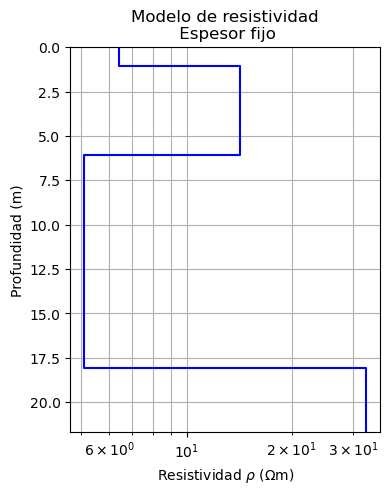

In [26]:
fig, ax = plt.subplots(figsize=(4,5))
drawModel1D(model=model_f, ax=ax, color='blue', label="Espesor fijo", plot='semilogx')
ax.set_xlabel(r"Resistividad $\rho$ ($\Omega$m)")
ax.set_ylabel("Profundidad (m)")
ax.set_title("Modelo de resistividad\n Espesor fijo")
ax.grid(True, which='both')

# plt.savefig("figs/" + vescode + "-espesor-fijo.png", dpi=300, bbox_inches='tight')

<positron-console-cell-27>:6: SyntaxWarning: invalid escape sequence '\c'


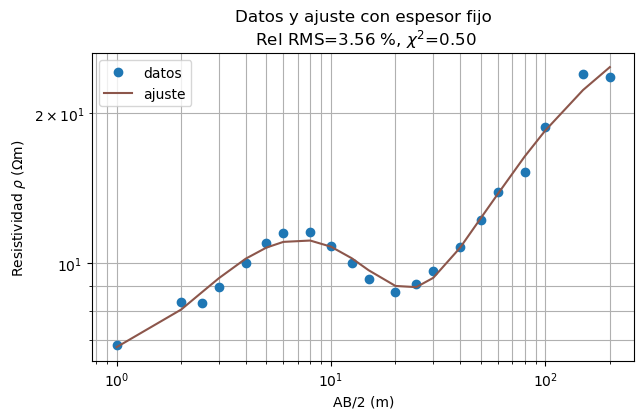

In [27]:
fig, ax = plt.subplots(figsize=(7,4))
ax.loglog(ab2, rhoa, 'o', color="C0", label='datos')
ax.loglog(ab2, inv_f.response, '-', color="C5", label='ajuste')
ax.set_xlabel("AB/2 (m)")
ax.set_ylabel(r"Resistividad $\rho$ ($\Omega$m)")
ax.set_title("Datos y ajuste con espesor fijo\n Rel RMS={:.2f} %, $\chi^2$={:.2f}".format(inv_f.relrms(), inv_f.chi2()))
ax.grid(True, which='both')
ax.legend(loc='best')

# plt.savefig("figs/" + vescode + "-espesor-fijo.png", dpi=300, bbox_inches='tight')

## Inversión con diferentes métodos y número de capas

Primero realizamos un ajuste con varias capas para observar la variación de los estadísticos de ajuste ($\chi^2$ y Rel RMS) con el número de capas. Esto nos ayuda a decidir el número óptimo de capas para la inversión final.

La inversión se puede correr con parámetros por defecto o se pueden ajustar:
- `lam`: suavizado, mientras más alto mayor suavizado (20 es el defecto)
- `cType`: tipo de regularizacion, 1 es el defecto, 2 es mas suavizado

In [28]:
CType = 1 # Tipo de regularización
Lam = 20 # Parámetro de suavizado

In [29]:
min_ncapas = 2 # Número mínimo de capas a probar
max_ncapas = 7 # Número máximo de capas a probar
capas = np.arange(min_ncapas, max_ncapas+1)

### Inversión con MarquardtInversion

In [30]:
invs_m = []
mods_m = []
chi2s_m = []
rmss_m = []

for h in capas:
    fop_m = VESModelling(ab2=ab2,
                         mn2=mn2,
                         nLayers=h
                         )
    inv_m = MarquardtInversion(fop=fop_m, verbose=True)
    inv_m.dataTrans = 'log'
    invs_m.append(inv_m)
    mod_m = inv_m.run(rhoa, err, lam=Lam, verbose=False)
    mods_m.append(mod_m)
    chi2s_m.append(inv_m.chi2())
    rmss_m.append(inv_m.relrms())

07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:13 - pyGIMLi - WARNING - Multiprocess 

<positron-console-cell-31>:2: SyntaxWarning: invalid escape sequence '\c'
<positron-console-cell-31>:15: SyntaxWarning: invalid escape sequence '\c'


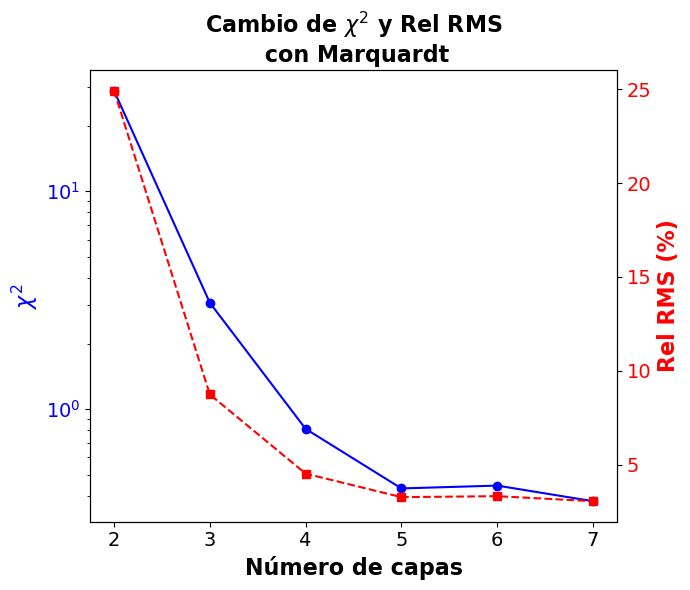

In [31]:
fig, ax1 = plt.subplots(figsize=(7,6))
ax1.set_ylabel('$\chi^2$', fontsize=16, fontweight='bold', color='blue')
ax1.set_xlabel('Número de capas', fontsize=16, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.semilogy(np.arange(2,h+1), chi2s_m, 'o-', color='b')

ax2 = ax1.twinx()

ax2.set_ylabel('Rel RMS (%)', fontsize=16, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2.plot(np.arange(2,h+1), rmss_m, 's--', color='r')

plt.title('Cambio de $\chi^2$ y Rel RMS\n con Marquardt', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

# plt.savefig("figs/" + vescode + "-chi2-marquardt-.png", dpi=300, bbox_inches='tight')

Es el cambio en $\chi^2$ significativo al aumentar el número de capas? Usamos la prueba estadística Chi-cuadrado para responder a esta pregunta.

In [32]:
chi2sig_m = np.append(np.nan,chi2.sf(abs(np.diff(chi2s_m)),2)) < .05

for n in capas:
    if chi2sig_m[n-min_ncapas] == True:
        print(str(n) + " capas \033[1msí\033[0m son significativas")
    else:
        print(str(n) + " capas \033[1mno\033[0m son significativas")

2 capas no son significativas
3 capas sí son significativas
4 capas no son significativas
5 capas no son significativas
6 capas no son significativas
7 capas no son significativas


### Inversión con VESManager

In [33]:
vess_vm = []
mods_vm = []
chi2s_vm = []
rmss_vm = []

for h in capas:
    ves_vm = VESManager(ab2 = ab2, 
                        mn2 = mn2
                        )
    mod_vm = ves_vm.invert(rhoa, err, 
                           nLayers=h, 
                           lam=Lam, lambdaFactor=0.8
                           )
    vess_vm.append(ves_vm)
    mods_vm.append(mod_vm)
    chi2s_vm.append(ves_vm.inv.chi2())
    rmss_vm.append(ves_vm.inv.relrms())

07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
07/11/25 - 08:56:27 - pyGIMLi - WARNING - Multiprocess 

<positron-console-cell-34>:2: SyntaxWarning: invalid escape sequence '\c'
<positron-console-cell-34>:15: SyntaxWarning: invalid escape sequence '\c'


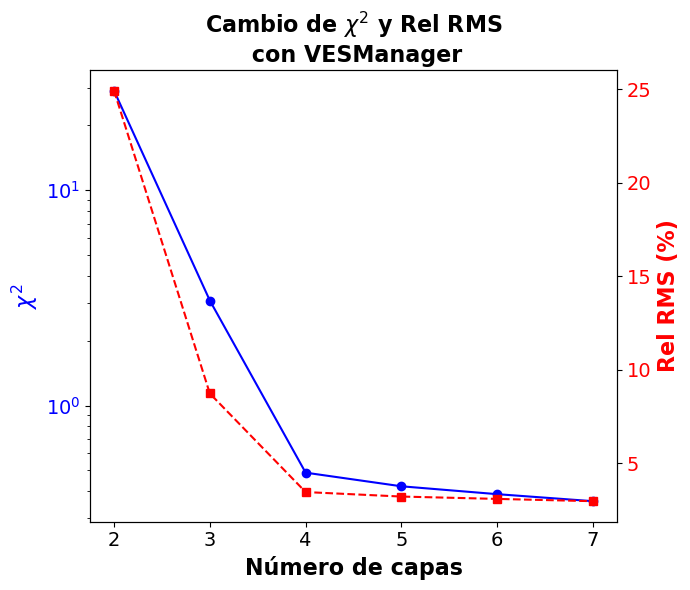

In [34]:
fig, ax1 = plt.subplots(figsize=(7,6))
ax1.set_ylabel('$\chi^2$', fontsize=16, fontweight='bold', color='blue')
ax1.set_xlabel('Número de capas', fontsize=16, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.semilogy(np.arange(2,h+1), chi2s_vm, 'o-', color='b')

ax2 = ax1.twinx()

ax2.set_ylabel('Rel RMS (%)', fontsize=16, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2.plot(np.arange(2,h+1), rmss_vm, 's--', color='r')

plt.title('Cambio de $\chi^2$ y Rel RMS\n con VESManager', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

# plt.savefig("figs/" + vescode + "-chi2-vesmanager-.png", dpi=300, bbox_inches='tight')

Es el cambio en $\chi^2$ significativo al aumentar el número de capas? Usamos la prueba estadística Chi-cuadrado para responder a esta pregunta.

In [35]:
chi2sig_vm = np.append(np.nan,chi2.sf(abs(np.diff(chi2s_vm)),2)) < .05

for n in capas:
    if chi2sig_vm[n-min_ncapas] == True:
        print(str(n) + " capas \033[1msí\033[0m son significativas")
    else:
        print(str(n) + " capas \033[1mno\033[0m son significativas")

2 capas no son significativas
3 capas sí son significativas
4 capas no son significativas
5 capas no son significativas
6 capas no son significativas
7 capas no son significativas


### Modelos de capas seleccionado

Una vez decidido el número de capas, se realiza la inversión con ambos métodos para comparar resultados.

In [36]:
ncapas = 4 # Número de capas en el modelo

In [37]:
fop = VESModelling(ab2=ab2,
                   mn2=mn2,
                   nLayers=ncapas
                   )
inv = MarquardtInversion(fop=fop, verbose=True)
inv.dataTrans = 'log'

In [38]:
inv.setRegularization(cType=CType)

In [ ]:
model = inv.run(rhoa, err, lam=Lam, verbose=True)

Si no se quieren cambiar parámetros de la inversión, se pueden escoger los modelos ya calculados en el ciclo anterior.

In [39]:
inv = invs_m[ncapas - min_ncapas]
model = mods_m[ncapas - min_ncapas]

In [40]:
print(f"\u03C7^2: {inv.chi2():.2f}")
print(f"Rel RMS: {inv.relrms():.2f} %")

χ^2: 0.81
Rel RMS: 4.53 %


In [41]:
ves = VESManager(ab2 = ab2, 
                 mn2 = mn2
                )

In [ ]:
ves.inv.setRegularization(cType=CType)

In [ ]:
model2 = ves.invert(rhoa, err, 
                    nLayers=ncapas, 
                    lam=Lam, lambdaFactor=0.8
                    )

Si no se quieren cambiar parámetros de la inversión, se pueden escoger los modelos ya calculados en el ciclo anterior.

In [42]:
ves = vess_vm[ncapas - min_ncapas]
model2 = mods_vm[ncapas - min_ncapas]

In [43]:
print(f"\u03C7^2: {ves.inv.chi2():.2f}")
print(f"Rel RMS: {ves.inv.relrms():.2f} %")

χ^2: 0.49
Rel RMS: 3.47 %


Grafica comparativa de los resultados de los métodos de inversión. Primero los datos y los ajustes, y luego los modelos de resistividad.

Text(0.5, 1.0, 'Datos y ajuste\n (4 capas)')

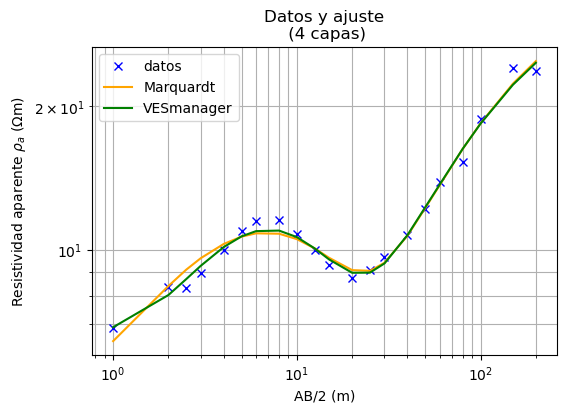

In [44]:
fig, ax = plt.subplots(figsize=(6,4))

ax.loglog(ab2, rhoa, "x", color='blue', label="datos")
ax.loglog(ab2, inv.response, "-", color='orange', label="Marquardt")
ax.loglog(ab2, ves.inv.response, "-", color='green', label="VESmanager")
ax.legend()
ax.grid(True, which='both')
ax.set_ylabel(r"Resistividad aparente $\rho_a$ ($\Omega$m)")
ax.set_xlabel("AB/2 (m)")
ax.set_title("Datos y ajuste\n" + f" ({ncapas} capas)")

# plt.savefig("figs/" + vescode + "-fit-modelos-" + str(ncapas) + "capas.png", dpi=300, bbox_inches='tight')

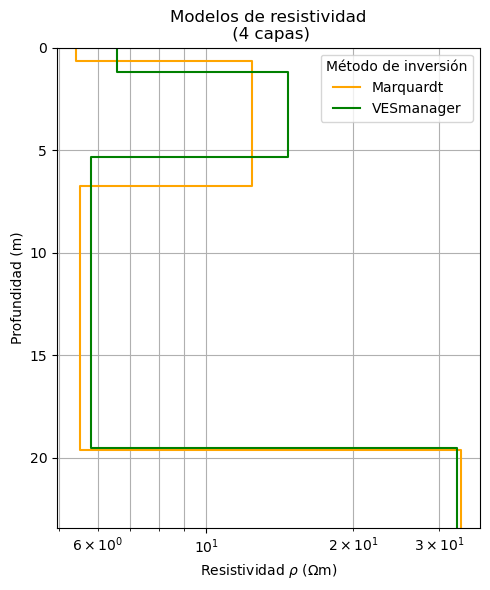

In [45]:
fig, ax = plt.subplots(figsize=(5,6))

drawModel1D(model=model, ax=ax, color='orange', label="Marquardt", plot='semilogx')
drawModel1D(model=model2, ax=ax, color='green', label="VESmanager", plot='semilogx')

ax.grid(True, which='both')
ax.set_ylabel("Profundidad (m)")
ax.set_xlabel(r"Resistividad $\rho$ ($\Omega$m)")
ax.set_title("Modelos de resistividad\n" + f" ({ncapas} capas)")
ax.legend(loc='best',title="Método de inversión")
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

# plt.savefig("figs/" + vescode + "-modelos-" + str(ncapas) + "capas.png", dpi=300, bbox_inches='tight')

## Ajuste final y análisis del modelo

Escogemos el modelo deseado para análisis posterior.

In [46]:
Inv = ves.inv # inv o ves.inv
Model = model2 # model o model2
Response = Inv.response
Chi2 = Inv.chi2()
RelRMS = Inv.relrms()

print(f"\u03C7^2: {Chi2:.2f}")
print(f"Rel RMS: {RelRMS:.2f} %")

χ^2: 0.49
Rel RMS: 3.47 %


### Resultados del modelo: espesores y resistividades.

In [47]:
thk = Model[:ncapas-1] # Espesores
res = Model[ncapas-1:] # Resistividades

print("Modelo:", round(Model,2))
print("Espesores (m):", round(thk,2))
print(f"Resistividades \u03C1 (Ohm.m):", round(res,2))
print("Profundidad (m): " + str(round(np.cumsum(round(thk,2))[-1],2)))

Modelo: [ 1.16  4.17 14.2   6.59 14.71  5.81 32.59]
Espesores (m): [ 1.16  4.17 14.2 ]
Resistividades ρ (Ohm.m): [ 6.59 14.71  5.81 32.59]
Profundidad (m): 19.53


In [48]:
veslist = ["Modelo de resistividad\n", 
           "Espesores (m): " + str(list(map(str,round(thk,2)))) + "\n", 
           f"Resistividades \u03C1 (Ohm.m): " + str(list(map(str,round(res,2)))) + "\n",
           "Profundidad (m): " + str(round(np.cumsum(round(thk,2))[-1],2)) + "\n",
           "\n",
           "Estadísticas del ajuste\n",
           f"\u03C7^2: {Chi2:.2f}\n",
           f"Rel RMS: {RelRMS:.2f} %\n"]

with open(vescode + "-modelo-" + str(ncapas) + "capas.txt", "w") as f:
    f.writelines(veslist)

In [49]:
mod_pd = pd.DataFrame(data={
                        'Capa': np.arange(1,ncapas+1),
                        'Espesor': np.append(round(thk,2),np.nan),
                        'Resistividad': round(res,2),
                        'Profundidad (m)': np.append(np.cumsum(round(thk,2)), np.nan)
                            }
                      )
print(mod_pd)

   Capa  Espesor  Resistividad  Profundidad (m)
0     1     1.16          6.59             1.16
1     2     4.17         14.71             5.33
2     3    14.20          5.81            19.53
3     4      NaN         32.59              NaN


### Grafica de ajuste

<positron-console-cell-50>:11: SyntaxWarning: invalid escape sequence '\c'


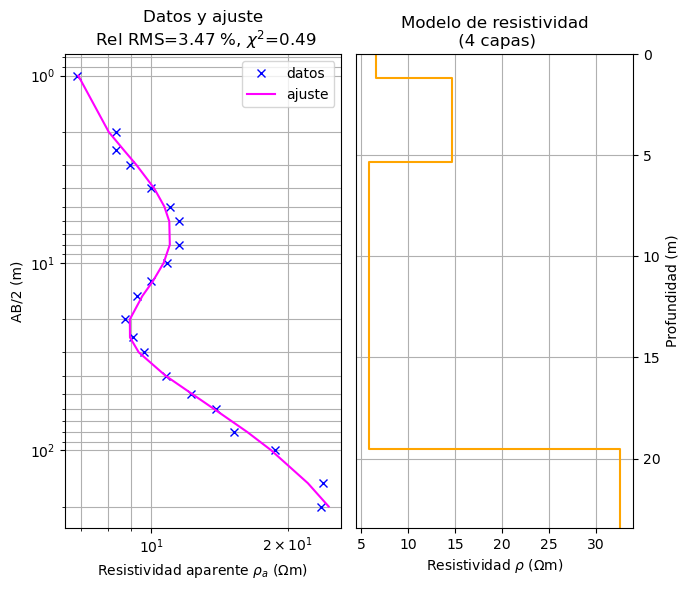

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(7,6))

ax[0].loglog(rhoa, ab2, "x", color='blue', label="datos")
ax[0].loglog(Response, ab2, "-", color='magenta', label="ajuste")
# drawModel1D(model=Model, ax=ax[0], color='orange', label="modelo", plot='loglog'); ax[0].set_ylim(max(ab2)*1.1, min(ab2)*0.9)
ax[0].invert_yaxis()
ax[0].legend()
ax[0].grid(True, which='both')
ax[0].set_xlabel(r"Resistividad aparente $\rho_a$ ($\Omega$m)")
ax[0].set_ylabel("AB/2 (m)")
ax[0].set_title("Datos y ajuste\n Rel RMS={:.2f} %, $\chi^2$={:.2f}".format(RelRMS, Chi2))

drawModel1D(model=Model, ax=ax[1], color='orange')
ax[1].grid(True, which='both')
ax[1].set_ylabel("Profundidad (m)")
ax[1].set_xlabel(r"Resistividad $\rho$ ($\Omega$m)")
ax[1].set_title("Modelo de resistividad\n" + f" ({ncapas} capas)")
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.set_ticks_position('right')

plt.tight_layout()
plt.show()

# plt.savefig("figs/" + vescode + "-fit-" + str(ncapas) + "capas.png", dpi=300, bbox_inches='tight')

### Incertidumbre del modelo

La incertidumbre del modelo se puede estimar a partir de la matriz de covarianza del modelo. Estas incertidumbres proporcionan una idea de la confiabilidad de los parámetros del modelo, y se pueden visualizar en una matriz de correlación, así como en barras de error en el modelo de resistividad y espesores.

07/11/25 - 08:58:28 - pyGIMLi - INFO - [0.35206322 0.82269663 0.72299144 0.07153623 0.26262385 0.42607883 0.09962559]


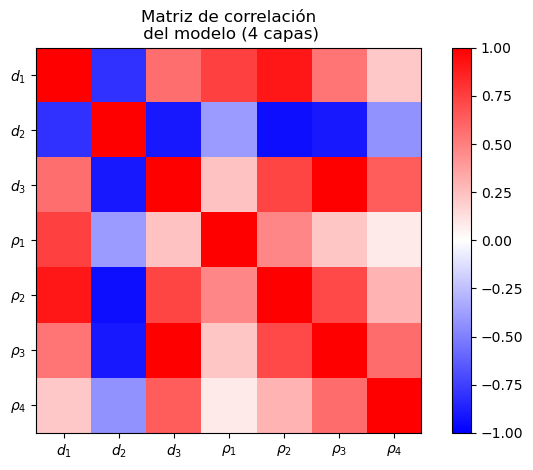

In [51]:
var, MCM = modelCovariance(Inv)
pg.info(var)

fig, ax = plt.subplots()
im = ax.imshow(MCM, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
labels = [rf'$d_{i+1}$' for i in range(ncapas-1)] + \
    [rf'$\rho_{i+1}$' for i in range(ncapas)]
plt.xticks(np.arange(ncapas*2-1), labels)
_ = plt.yticks(np.arange(ncapas*2-1), labels)
plt.title("Matriz de correlación\n del modelo" + f" ({ncapas} capas)")

plt.tight_layout()
plt.show()

# plt.savefig("figs/" + vescode + "-correl-" + str(ncapas) + "capas.png", dpi=300, bbox_inches='tight')

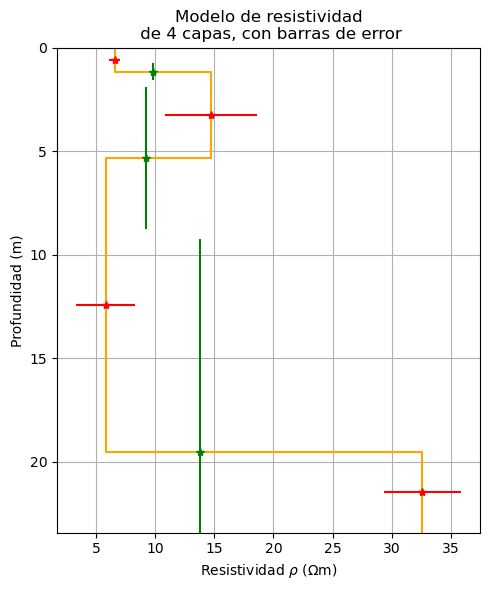

In [52]:
z = np.cumsum(thk)
mid = np.hstack([z - thk/2, z[-1]*1.1])
resmean = np.sqrt(res[:-1]*res[1:])

fig, ax = plt.subplots(figsize=(5,6))

res_error = res * (var[ncapas-1:])
thk_error = thk * var[:ncapas-1]

drawModel1D(model=Model, ax=ax, color='orange', label="model")
ax.errorbar(res, mid, marker="*", color='red', ls="None", xerr=res_error)
_ = ax.errorbar(resmean, z, marker="*", color='green', ls="None", yerr=thk_error)
ax.grid(True, which='both')
ax.set_ylabel("Profundidad (m)")
ax.set_xlabel(r"Resistividad $\rho$ ($\Omega$m)")
ax.set_title("Modelo de resistividad\n" + f" de {ncapas} capas" + ", con barras de error")

plt.tight_layout()
plt.show()

# plt.savefig("figs/" + vescode + "-fit-errorbars-" + str(ncapas) + "capas.png", dpi=300, bbox_inches='tight')